In [2]:
import wandb
import wandb
from wandb.keras import WandbCallback
import os
import cv2
import keras.callbacks
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [43]:
#Initial wandb
wandb.init(project="planet-segmentation-unet", entity="koltigis")

accuracy,__main__.jaccard_coe...
loss,<segmentation_models...


In [5]:
# MinMaxScaler
minmaxscaler = MinMaxScaler()

# Dataset path
dataset_root_folder = 'C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet'
dataset_name = 'semantic_segmentation_dataset'

- **for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):** adalah perulangan **for** yang menggunakan **os.walk** untuk menjelajahi setiap direktori dan file yang ada di dalam **dataset_root_folder/dataset_name**
- **dir_name = path.split(os.path.sep)[-1]** yaitu :
**path.split(os.path.sep)** memecah string path menjadi bagian-bagian berdasarkan separator path. Misalnya, jika path adalah **'folder1/folder2/folder3'**, pemisahan tersebut akan menghasilkan list **['folder1', 'folder2', 'folder3']**
**[-1]** digunakan untuk mengakses elemen terakhir dari list yang dihasilkan. Dalam contoh di atas, ini akan menghasilkan 'folder3'
- **if dir_name == 'masks':**  Pernyataan ini memeriksa apakah direktori saat ini memiliki nama 'masks'
- **images = os.listdir(path):** Baris ini mengambil daftar file yang ada dalam direktori saat ini (path)

In [6]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
    dir_name = path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == 'masks':
        images = os.listdir(path)
        print(path)
        # print(images)
        for i, image_name in enumerate(images):
            if (image_name.endswith('.png')):
                # print(image_name)
                a = True

C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 1\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 2\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 3\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 4\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet\semantic_segmentation_dataset\Tile 5\masks
C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_

In [7]:
image_patch_size = 256
image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg')
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step= image_patch_size)
image_x = image_patches[0,0,:,:]
image_y = minmaxscaler.fit_transform(image_x.reshape(-1, image_x.shape[-1])).reshape(image_x.shape)
image_y.shape

(1, 256, 256, 3)

In [8]:
# from PIL import Image

image_dataset = []
mask_dataset = []

for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'
    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):  # Perbaikan pada dimensi indeks
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            # print(individual_patched_image.shape)
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [9]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


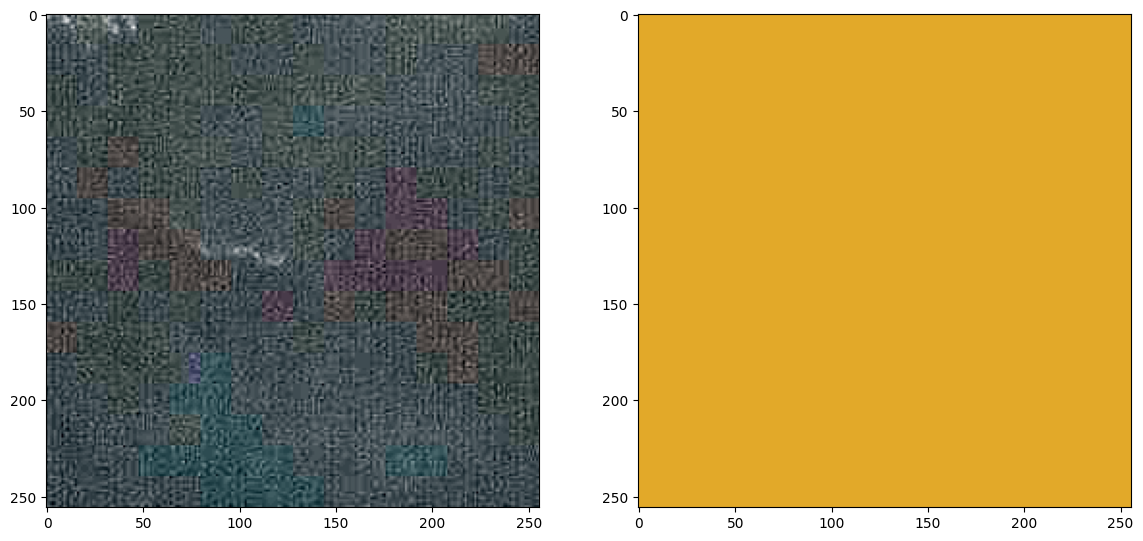

In [10]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [11]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [12]:
label = individual_patched_image
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:,:,0]
    # print(label_segment)
    return label_segment

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [15]:
labels = np.array(labels)
labels[3]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [16]:
labels = np.expand_dims(labels, axis=3)

In [17]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

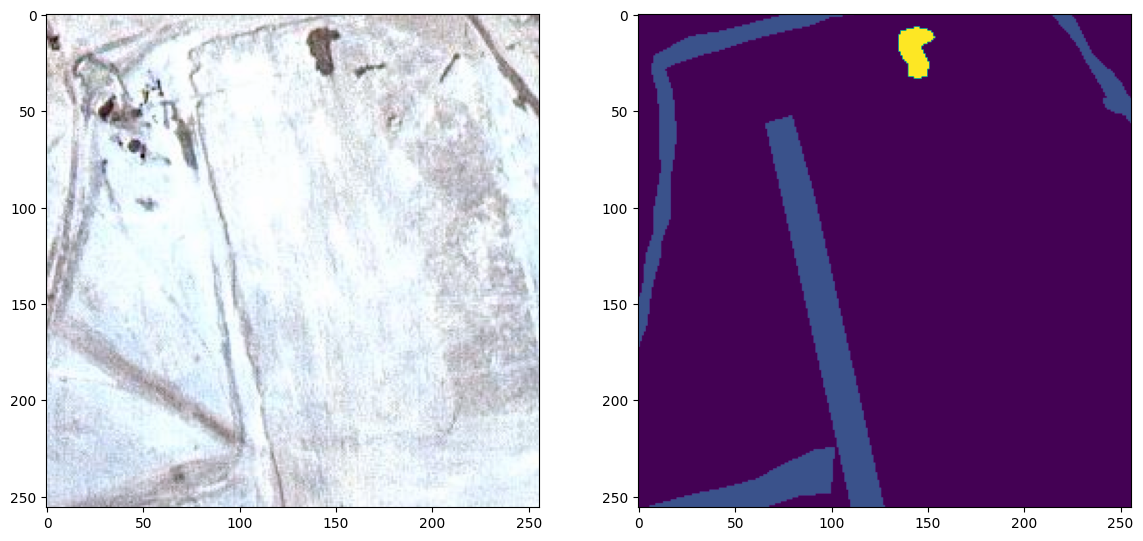

In [18]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

## Split Datasets

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [19]:
total_classes = len(np.unique(labels))
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [20]:
master_training_dataset = image_dataset
master_training_dataset.shape

(945, 256, 256, 3)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


**Output :**
(803, 256, 256, 3) => 803 image, ukuran 256 x 256, 3 band
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6) => 803 mask, ukuran 256 x 256, 6 kelas

In [24]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
image_class = y_train.shape[3]

In [25]:
print(f"Image height : {image_height}")
print(f"Image width : {image_width}")
print(f"Image channels : {image_channels}")
print(f"Image class : {image_class}")

Image height : 256
Image width : 256
Image channels : 3
Image class : 6


## Create IoU -> create model architecture -> Fit the model -> generating loss

In [26]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [27]:
from keras import backend as K

In [35]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [28]:
# Create IoU (Jaccard coefision)
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [29]:
# Create model architecture
def multi_unet_model(n_class=5, image_height=256, image_width=256, image_channels=1):

    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(n_class, (1,1), activation="softmax")(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [30]:
metrics = ["accuracy", jaccard_coef]

In [31]:
def get_deep_learning_model():
    return multi_unet_model(n_class=total_classes,
                            image_height=image_height,
                            image_width=image_width,
                            image_channels=image_channels)

In [32]:
model = get_deep_learning_model()

In [36]:
# Generating loss function
# total_loss = (dice_loss + (1 * focal_loss)
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

## Model Compilation

In [44]:
import tensorflow as tf
from IPython.display import clear_output
%matplotlib inline

In [45]:
tf.keras.backend.clear_session()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [46]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();

plot_loss = PlotLoss()

In [40]:
# wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})

In [41]:
# wandb.config.dropout = 0.2

In [47]:
my_callback_object = WandbCallback()
x_train = np.array(x_train)
y_train = np.array(y_train)

model_history = model.fit(x_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(x_test, y_test),
                          callbacks=[my_callback_object],
                          shuffle=False)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.6114 - jaccard_coef: 0.3064

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 330s 6s/step - loss: 0.9928 - accuracy: 0.6114 - jaccard_coef: 0.3064 - val_loss: 0.9747 - val_accuracy: 0.6972 - val_jaccard_coef: 0.3472
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.9663 - accuracy: 0.7079 - jaccard_coef: 0.4360

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 312s 6s/step - loss: 0.9663 - accuracy: 0.7079 - jaccard_coef: 0.4360 - val_loss: 0.9714 - val_accuracy: 0.6747 - val_jaccard_coef: 0.4547
Epoch 3/100
51/51 [==============================] - 318s 6s/step - loss: 0.9553 - accuracy: 0.7384 - jaccard_coef: 0.4969 - val_loss: 0.9731 - val_accuracy: 0.6814 - val_jaccard_coef: 0.4500
Epoch 4/100
51/51 [==============================] - 302s 6s/step - loss: 0.9508 - accuracy: 0.7488 - jaccard_coef: 0.5111 - val_loss: 0.9865 - val_accuracy: 0.6517 - val_jaccard_coef: 0.4338
Epoch 5/100
51/51 [==============================] - ETA: 0s - loss: 0.9461 - accuracy: 0.7607 - jaccard_coef: 0.5373

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 277s 5s/step - loss: 0.9461 - accuracy: 0.7607 - jaccard_coef: 0.5373 - val_loss: 0.9712 - val_accuracy: 0.7058 - val_jaccard_coef: 0.4885
Epoch 6/100
51/51 [==============================] - 268s 5s/step - loss: 0.9398 - accuracy: 0.7815 - jaccard_coef: 0.5706 - val_loss: 0.9734 - val_accuracy: 0.7078 - val_jaccard_coef: 0.4967
Epoch 7/100
51/51 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.7922 - jaccard_coef: 0.5897

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 273s 5s/step - loss: 0.9358 - accuracy: 0.7922 - jaccard_coef: 0.5897 - val_loss: 0.9674 - val_accuracy: 0.7172 - val_jaccard_coef: 0.5159
Epoch 8/100
51/51 [==============================] - ETA: 0s - loss: 0.9325 - accuracy: 0.8009 - jaccard_coef: 0.6046

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 271s 5s/step - loss: 0.9325 - accuracy: 0.8009 - jaccard_coef: 0.6046 - val_loss: 0.9429 - val_accuracy: 0.7751 - val_jaccard_coef: 0.5787
Epoch 9/100
51/51 [==============================] - ETA: 0s - loss: 0.9287 - accuracy: 0.8113 - jaccard_coef: 0.6227

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 270s 5s/step - loss: 0.9287 - accuracy: 0.8113 - jaccard_coef: 0.6227 - val_loss: 0.9381 - val_accuracy: 0.7910 - val_jaccard_coef: 0.5998
Epoch 10/100
51/51 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.8214 - jaccard_coef: 0.6387

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 271s 5s/step - loss: 0.9250 - accuracy: 0.8214 - jaccard_coef: 0.6387 - val_loss: 0.9377 - val_accuracy: 0.7909 - val_jaccard_coef: 0.6142
Epoch 11/100
51/51 [==============================] - 268s 5s/step - loss: 0.9254 - accuracy: 0.8204 - jaccard_coef: 0.6359 - val_loss: 0.9480 - val_accuracy: 0.7655 - val_jaccard_coef: 0.5813
Epoch 12/100
51/51 [==============================] - 266s 5s/step - loss: 0.9256 - accuracy: 0.8180 - jaccard_coef: 0.6341 - val_loss: 0.9413 - val_accuracy: 0.7803 - val_jaccard_coef: 0.6071
Epoch 13/100
51/51 [==============================] - 266s 5s/step - loss: 0.9207 - accuracy: 0.8324 - jaccard_coef: 0.6595 - val_loss: 0.9409 - val_accuracy: 0.7827 - val_jaccard_coef: 0.6120
Epoch 14/100
51/51 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.8277 - jaccard_coef: 0.6503

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 269s 5s/step - loss: 0.9221 - accuracy: 0.8277 - jaccard_coef: 0.6503 - val_loss: 0.9358 - val_accuracy: 0.7884 - val_jaccard_coef: 0.6099
Epoch 15/100
51/51 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.8344 - jaccard_coef: 0.6607

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 272s 5s/step - loss: 0.9201 - accuracy: 0.8344 - jaccard_coef: 0.6607 - val_loss: 0.9303 - val_accuracy: 0.8084 - val_jaccard_coef: 0.6343
Epoch 16/100
51/51 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.8406 - jaccard_coef: 0.6710

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 270s 5s/step - loss: 0.9178 - accuracy: 0.8406 - jaccard_coef: 0.6710 - val_loss: 0.9299 - val_accuracy: 0.8118 - val_jaccard_coef: 0.6488
Epoch 17/100
51/51 [==============================] - 266s 5s/step - loss: 0.9158 - accuracy: 0.8454 - jaccard_coef: 0.6807 - val_loss: 0.9301 - val_accuracy: 0.8090 - val_jaccard_coef: 0.6448
Epoch 18/100
51/51 [==============================] - 265s 5s/step - loss: 0.9149 - accuracy: 0.8479 - jaccard_coef: 0.6829 - val_loss: 0.9320 - val_accuracy: 0.8069 - val_jaccard_coef: 0.6443
Epoch 19/100
51/51 [==============================] - 266s 5s/step - loss: 0.9144 - accuracy: 0.8493 - jaccard_coef: 0.6862 - val_loss: 0.9344 - val_accuracy: 0.8024 - val_jaccard_coef: 0.6350
Epoch 20/100
51/51 [==============================] - 264s 5s/step - loss: 0.9134 - accuracy: 0.8525 - jaccard_coef: 0.6909 - val_loss: 0.9317 - val_accuracy: 0.8082 - val_jaccard_coef: 0.6443
Epoch 21/100
51/51 [============================

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 270s 5s/step - loss: 0.9126 - accuracy: 0.8545 - jaccard_coef: 0.6947 - val_loss: 0.9274 - val_accuracy: 0.8185 - val_jaccard_coef: 0.6581
Epoch 22/100
51/51 [==============================] - 265s 5s/step - loss: 0.9131 - accuracy: 0.8542 - jaccard_coef: 0.6936 - val_loss: 0.9274 - val_accuracy: 0.8182 - val_jaccard_coef: 0.6578
Epoch 23/100
51/51 [==============================] - 264s 5s/step - loss: 0.9115 - accuracy: 0.8576 - jaccard_coef: 0.6995 - val_loss: 0.9276 - val_accuracy: 0.8183 - val_jaccard_coef: 0.6592
Epoch 24/100
51/51 [==============================] - ETA: 0s - loss: 0.9097 - accuracy: 0.8626 - jaccard_coef: 0.7069

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 269s 5s/step - loss: 0.9097 - accuracy: 0.8626 - jaccard_coef: 0.7069 - val_loss: 0.9224 - val_accuracy: 0.8308 - val_jaccard_coef: 0.6773
Epoch 25/100
51/51 [==============================] - 266s 5s/step - loss: 0.9085 - accuracy: 0.8667 - jaccard_coef: 0.7145 - val_loss: 0.9245 - val_accuracy: 0.8276 - val_jaccard_coef: 0.6726
Epoch 26/100
51/51 [==============================] - 266s 5s/step - loss: 0.9073 - accuracy: 0.8698 - jaccard_coef: 0.7189 - val_loss: 0.9239 - val_accuracy: 0.8317 - val_jaccard_coef: 0.6787
Epoch 27/100
51/51 [==============================] - 264s 5s/step - loss: 0.9074 - accuracy: 0.8697 - jaccard_coef: 0.7181 - val_loss: 0.9232 - val_accuracy: 0.8346 - val_jaccard_coef: 0.6860
Epoch 28/100
51/51 [==============================] - ETA: 0s - loss: 0.9064 - accuracy: 0.8724 - jaccard_coef: 0.7226

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 279s 5s/step - loss: 0.9064 - accuracy: 0.8724 - jaccard_coef: 0.7226 - val_loss: 0.9206 - val_accuracy: 0.8409 - val_jaccard_coef: 0.6914
Epoch 29/100
51/51 [==============================] - ETA: 0s - loss: 0.9060 - accuracy: 0.8738 - jaccard_coef: 0.7250

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 271s 5s/step - loss: 0.9060 - accuracy: 0.8738 - jaccard_coef: 0.7250 - val_loss: 0.9176 - val_accuracy: 0.8464 - val_jaccard_coef: 0.6980
Epoch 30/100
51/51 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.8762 - jaccard_coef: 0.7278

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 270s 5s/step - loss: 0.9049 - accuracy: 0.8762 - jaccard_coef: 0.7278 - val_loss: 0.9168 - val_accuracy: 0.8513 - val_jaccard_coef: 0.7105
Epoch 31/100
51/51 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.8762 - jaccard_coef: 0.7286

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 271s 5s/step - loss: 0.9049 - accuracy: 0.8762 - jaccard_coef: 0.7286 - val_loss: 0.9150 - val_accuracy: 0.8522 - val_jaccard_coef: 0.7048
Epoch 32/100
51/51 [==============================] - 267s 5s/step - loss: 0.9040 - accuracy: 0.8785 - jaccard_coef: 0.7331 - val_loss: 0.9161 - val_accuracy: 0.8496 - val_jaccard_coef: 0.7008
Epoch 33/100
51/51 [==============================] - ETA: 0s - loss: 0.9044 - accuracy: 0.8773 - jaccard_coef: 0.7317

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 271s 5s/step - loss: 0.9044 - accuracy: 0.8773 - jaccard_coef: 0.7317 - val_loss: 0.9146 - val_accuracy: 0.8542 - val_jaccard_coef: 0.7039
Epoch 34/100
51/51 [==============================] - 265s 5s/step - loss: 0.9043 - accuracy: 0.8778 - jaccard_coef: 0.7318 - val_loss: 0.9218 - val_accuracy: 0.8376 - val_jaccard_coef: 0.6820
Epoch 35/100
51/51 [==============================] - 265s 5s/step - loss: 0.9018 - accuracy: 0.8845 - jaccard_coef: 0.7431 - val_loss: 0.9207 - val_accuracy: 0.8383 - val_jaccard_coef: 0.6923
Epoch 36/100
51/51 [==============================] - 266s 5s/step - loss: 0.9059 - accuracy: 0.8739 - jaccard_coef: 0.7268 - val_loss: 0.9271 - val_accuracy: 0.8172 - val_jaccard_coef: 0.6456
Epoch 37/100
51/51 [==============================] - 265s 5s/step - loss: 0.9061 - accuracy: 0.8728 - jaccard_coef: 0.7229 - val_loss: 0.9204 - val_accuracy: 0.8350 - val_jaccard_coef: 0.6736
Epoch 38/100
51/51 [============================

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 271s 5s/step - loss: 0.8967 - accuracy: 0.8915 - jaccard_coef: 0.7684 - val_loss: 0.9128 - val_accuracy: 0.8541 - val_jaccard_coef: 0.7218
Epoch 43/100
51/51 [==============================] - 266s 5s/step - loss: 0.8956 - accuracy: 0.8935 - jaccard_coef: 0.7747 - val_loss: 0.9128 - val_accuracy: 0.8531 - val_jaccard_coef: 0.7225
Epoch 44/100
51/51 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.8890 - jaccard_coef: 0.7650

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 269s 5s/step - loss: 0.8965 - accuracy: 0.8890 - jaccard_coef: 0.7650 - val_loss: 0.9118 - val_accuracy: 0.8546 - val_jaccard_coef: 0.7192
Epoch 45/100
51/51 [==============================] - ETA: 0s - loss: 0.8978 - accuracy: 0.8853 - jaccard_coef: 0.7603

INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\dimas.perceka\OneDrive - Koltiva\Desktop\Belajar\Deep Learning\Rob_cole\j_planet-segmentation-unet\j_planet-segmentation-unet\wandb\run-20230615_231139-jud1557z\files\model-best)... Done. 0.1s


51/51 [==============================] - 290s 6s/step - loss: 0.8978 - accuracy: 0.8853 - jaccard_coef: 0.7603 - val_loss: 0.9112 - val_accuracy: 0.8589 - val_jaccard_coef: 0.7291
Epoch 46/100
51/51 [==============================] - 266s 5s/step - loss: 0.8974 - accuracy: 0.8850 - jaccard_coef: 0.7602 - val_loss: 0.9158 - val_accuracy: 0.8514 - val_jaccard_coef: 0.7159
Epoch 47/100
18/51 [=========>....................] - ETA: 2:49 - loss: 0.9018 - accuracy: 0.8820 - jaccard_coef: 0.7546